In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from monks_data_loader import load_monk_data
import matplotlib.pyplot as plt
from monk_utils import *
import seaborn as sns
import numpy as np

In [25]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [26]:
monk_ids = [1, 2, 3]
best_params = {}

Monk dataset id: 1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Baseline accuracy: 0.50 (class: 0)

Best parameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Best CV accuracy: 81.47 %

TR accuracy: 100.00 %
Test accuracy: 55.32 %
Train Validation delta: 44.68 %
CV Mean: 81.47 %

              precision    recall  f1-score   support

           0       0.55      0.54      0.55       216
           1       0.55      0.56      0.56       216

    accuracy                           0.55       432
   macro avg       0.55      0.55      0.55       432
weighted avg       0.55      0.55      0.55       432



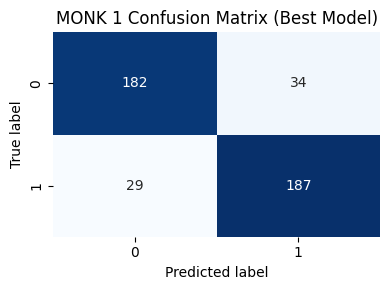

Monk dataset id: 2
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Baseline accuracy: 0.67 (class: 0)

Best parameters: {'weights': 'uniform', 'n_neighbors': 8, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Best CV accuracy: 66.88 %

TR accuracy: 68.64 %
Test accuracy: 48.38 %
Train Validation delta: 20.26 %
CV Mean: 66.88 %

              precision    recall  f1-score   support

           0       0.66      0.48      0.55       290
           1       0.32      0.49      0.39       142

    accuracy                           0.48       432
   macro avg       0.49      0.49      0.47       432
weighted avg       0.55      0.48      0.50       432



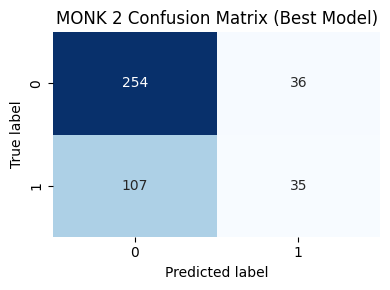

Monk dataset id: 3
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Baseline accuracy: 0.47 (class: 0)

Best parameters: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'manhattan', 'algorithm': 'brute'}
Best CV accuracy: 87.67 %

TR accuracy: 100.00 %
Test accuracy: 90.97 %
Train Validation delta: 9.03 %
CV Mean: 87.67 %

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       204
           1       0.93      0.90      0.91       228

    accuracy                           0.91       432
   macro avg       0.91      0.91      0.91       432
weighted avg       0.91      0.91      0.91       432



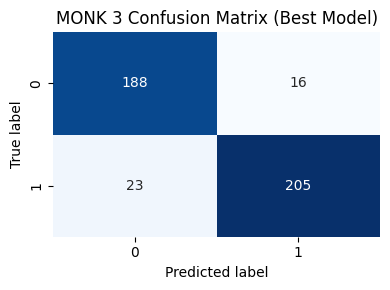

In [27]:

for monk_dataset_id in monk_ids:
    print(f"Monk dataset id: {monk_dataset_id}")
    X_train, y_train, X_test, y_test = load_monk_data(monk_dataset_id)

    knn = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    params_grid = {
        "n_neighbors": range(1, 12),
        "weights": ["uniform", "distance"],
        "algorithm": ["brute", "kd_tree", "ball_tree"],
        "metric": ["minkowski", "euclidean", "manhattan"]
    }

    random_search = RandomizedSearchCV(
        estimator=knn,
        param_distributions=params_grid,
        n_iter=100,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=42,
        return_train_score=True
    )

    random_search.fit(X_train, y_train)
    
    baseline_accuracy, most_freq_class = calculate_majority_baseline(y_train, y_test)
    print(f"Baseline accuracy: {baseline_accuracy:.2f} (class: {most_freq_class})")

    best_params_run = random_search.best_params_
    best_cv_score = random_search.best_score_
    
    print("")
    print(f"Best parameters: {best_params_run}")
    print(f"Best CV accuracy: {(best_cv_score*100):.2f} %")

    best_model = random_search.best_estimator_

    # run on test set
    y_test_results = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    tr_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    cv_mean = random_search.best_score_
    
    print("")
    print(f"TR accuracy: {(tr_acc*100):.2f} %")
    print(f"Test accuracy: {(test_acc*100):.2f} %")
    print(f"Train Validation delta: {((tr_acc - test_acc)*100):.2f} %")
    print(f"CV Mean: {(cv_mean*100):.2f} %")
    print("")
    
    best_params_run["tr_acc"] = tr_acc
    best_params_run["test_acc"] = test_acc
    best_params_run["cv_mean"] = cv_mean
    
    best_params[monk_dataset_id] = best_params_run

    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(
        y_test,
        y_test_results,
        title=f"MONK {monk_dataset_id} Confusion Matrix (Best Model)"
    )
    print("====================================")